In [114]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [115]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2640.7,539.2,1428.4,501.6,3.9,2.0
std,2.1,2.0,12.6,2174.7,421.6,1158.6,384.6,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,297.0,791.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,433.0,1169.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3144.2,647.0,1719.2,605.2,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2650.9,539.8,1432.4,500.4,3.9,2.0
std,2.1,2.0,12.7,2192.6,421.4,1121.6,384.4,1.9,1.4
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1462.0,295.0,787.8,279.0,2.6,1.5
50%,34.2,-118.5,28.0,2130.5,435.0,1163.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3168.5,652.0,1725.2,605.2,4.7,2.3
max,42.0,-114.5,52.0,32054.0,5290.0,15507.0,5050.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.7
std,116.2
min,15.0
25%,119.6
50%,180.8
75%,266.5
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.2
std,115.6
min,15.0
25%,119.3
50%,178.9
75%,260.6
max,500.0


In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

In [8]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 162.51
  period 01 : 159.87
  period 02 : 154.15
  period 03 : 145.79
  period 04 : 131.61
  period 05 : 115.47
  period 06 : 107.60
  period 07 : 105.78
  period 08 : 104.25
  period 09 : 102.70
Model training finished.
Final RMSE (on training data):   102.70
Final RMSE (on validation data): 103.61


In [116]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [117]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  examples_dataframe = examples_dataframe.copy()
  for col in examples_dataframe.columns:
        examples_dataframe[col] = linear_scale(examples_dataframe[col])
  return examples_dataframe

In [118]:
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

In [16]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 232.29
  period 01 : 212.16
  period 02 : 168.72
  period 03 : 119.68
  period 04 : 114.46
  period 05 : 110.69
  period 06 : 106.30
  period 07 : 101.14
  period 08 : 95.30
  period 09 : 89.02
Model training finished.
Final RMSE (on training data):   89.02
Final RMSE (on validation data): 90.18


In [119]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 70.59
  period 01 : 69.86
  period 02 : 69.91
  period 03 : 68.15


KeyboardInterrupt: 

In [21]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 118.06
  period 01 : 93.38
  period 02 : 72.55
  period 03 : 70.15
  period 04 : 69.43
  period 05 : 69.93
  period 06 : 68.55
  period 07 : 68.47
  period 08 : 68.14
  period 09 : 67.91
Model training finished.
Final RMSE (on training data):   67.91
Final RMSE (on validation data): 70.47


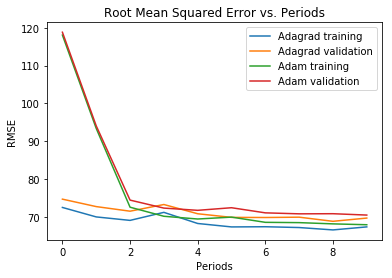

In [24]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

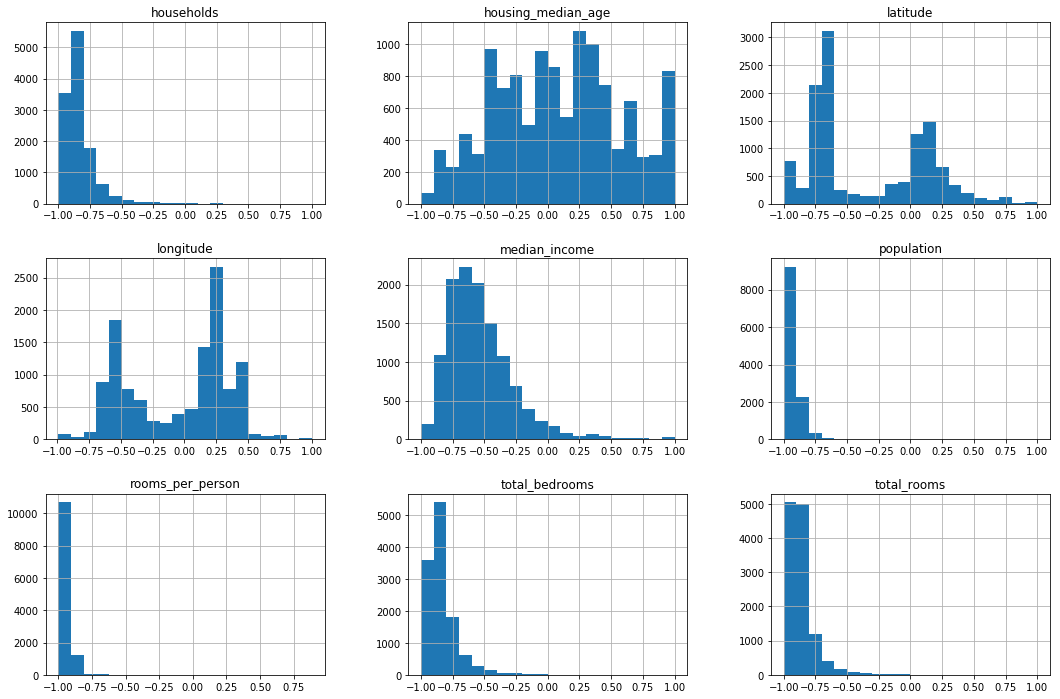

In [120]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [49]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [121]:
def normalize(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    #
    # YOUR CODE HERE: Normalize the inputs.
    # 
#     ["latitude",
#      "longitude",
#      "housing_median_age",
#      "total_rooms",
#      "total_bedrooms",
#      "population",
#      "households",
#      "median_income",
#      "rooms_per_person"]
    examples_dataframe = examples_dataframe.copy()
    examples_dataframe['households'] = log_normalize(examples_dataframe['households'])
    examples_dataframe['households'] = clip(z_score_normalize(examples_dataframe['households']),-3,3)
    
    examples_dataframe['median_income'] = log_normalize(examples_dataframe['median_income'])
    examples_dataframe['median_income'] = clip(z_score_normalize(examples_dataframe['median_income']),-3,3)
    
    examples_dataframe['population'] = log_normalize(examples_dataframe['population'])
    examples_dataframe['population'] = clip(z_score_normalize(examples_dataframe['population']),-3,3)
    
    examples_dataframe['rooms_per_person'] = log_normalize(examples_dataframe['rooms_per_person'])
    examples_dataframe['rooms_per_person'] = clip(z_score_normalize(examples_dataframe['rooms_per_person']),-3,3)
    
    
    examples_dataframe['total_bedrooms'] = log_normalize(examples_dataframe['total_bedrooms'])
    examples_dataframe['total_bedrooms'] = clip(z_score_normalize(examples_dataframe['total_bedrooms']),-3,3)
    
    examples_dataframe['total_rooms'] = log_normalize(examples_dataframe['total_rooms'])
    examples_dataframe['total_rooms'] = clip(z_score_normalize(examples_dataframe['total_rooms']),-3,3)
    
    examples_dataframe['housing_median_age'] = linear_scale(examples_dataframe['housing_median_age'])
    examples_dataframe['longitude'] = linear_scale(examples_dataframe['longitude'])
    examples_dataframe['latitude'] = linear_scale(examples_dataframe['latitude'])
    return examples_dataframe

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

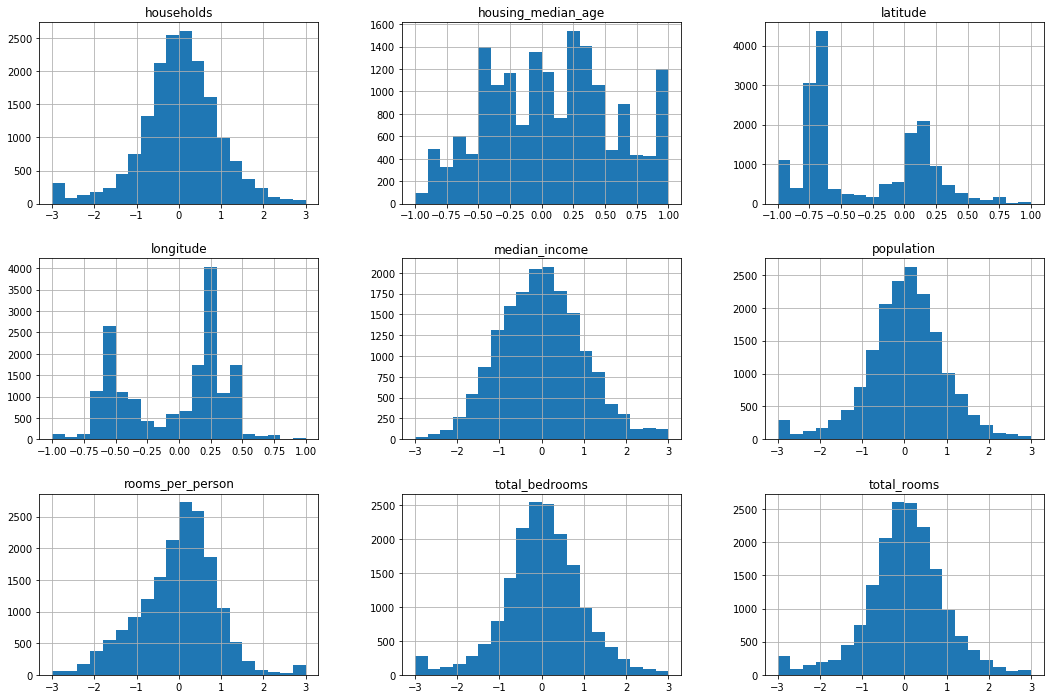

In [122]:
_ = normalized_dataframe.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [123]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 235.59
  period 01 : 228.44


KeyboardInterrupt: 

Training model...
RMSE (on training data):
  period 00 : 62.66
  period 01 : 60.68
  period 02 : 59.10
  period 03 : 58.76
  period 04 : 58.61
  period 05 : 59.00
  period 06 : 58.49
  period 07 : 58.55
  period 08 : 58.80
  period 09 : 58.30
Model training finished.
Final RMSE (on training data):   58.30
Final RMSE (on validation data): 58.27


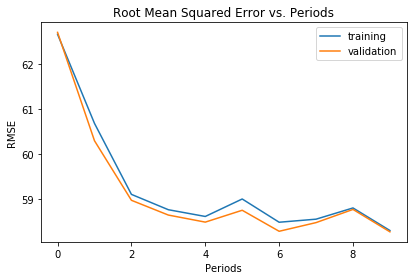

In [125]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=.5),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

In [126]:
def lat_lon(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    #
    # YOUR CODE HERE: Normalize the inputs.
    # 
#     ["latitude",
#      "longitude",
#      "housing_median_age",
#      "total_rooms",
#      "total_bedrooms",
#      "population",
#      "households",
#      "median_income",
#      "rooms_per_person"]
    res_df = pd.DataFrame()
    res_df['longitude'] = z_score_normalize(examples_dataframe['longitude'])
    res_df['latitude'] = z_score_normalize(examples_dataframe['latitude'])
    return res_df

lat_lon_dataframe = lat_lon(preprocess_features(california_housing_dataframe))
lat_lon_training_examples = lat_lon_dataframe.head(12000)
lat_lon_validation_examples = lat_lon_dataframe.tail(5000)

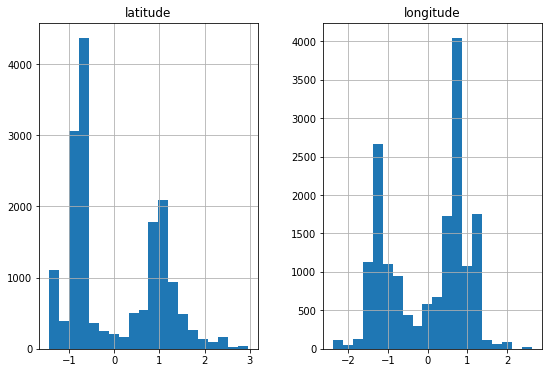

In [110]:
_ = lat_lon_dataframe.hist(bins=20, figsize=(9, 6), xlabelsize=10)

Training model...
RMSE (on training data):
  period 00 : 102.28
  period 01 : 98.85
  period 02 : 97.93
  period 03 : 97.32
  period 04 : 96.92
  period 05 : 96.59
  period 06 : 96.24
  period 07 : 95.86
  period 08 : 95.56
  period 09 : 95.07
Model training finished.
Final RMSE (on training data):   95.07
Final RMSE (on validation data): 95.60


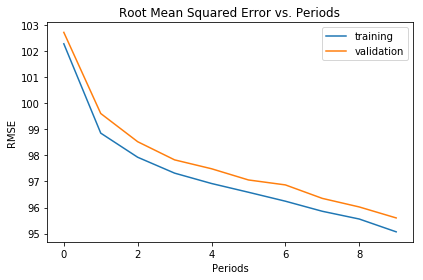

In [127]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=.05),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10, 6],
    training_examples=lat_lon_training_examples,
    training_targets=training_targets,
    validation_examples=lat_lon_validation_examples,
    validation_targets=validation_targets)